In [570]:
import time
from math import cos, pi, exp, e
import numpy
from numba import njit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [571]:
y = 5
n_args_count = 2  # количество x-ов, подаваемых в тестовую функцию
iter_max = 500  # больше 500 не нужно
number_of_agents = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight = 100  # максимальный вес рыбы

##Реализация алгоритма

In [572]:
@njit()
def main_function():
    step_ind = list()
    step_vol = list()
    p_qbest_list = list()  # массив p_qbest в разные моменты поколений
    # step_ind.append(float(input("Введите макс размер шага индивидуального перемещения: ")))
    # step_vol.append(float(input("Введите макс размер шага коллективно-волевого перемещения: ")))
    step_ind.append(0.005)
    step_vol.append(0.005)
    w = list()
    w.append(numpy.zeros(number_of_agents) + max_weight / 2)

    t = 0  # текущий номер поколения
    P = list()  # Начальная популяция
    P.append(generate_agents())  # Случано сгенерированное текущее поколение
    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    p_qbest_list.append(p_qbest)

    f_t = list()
    f_min = f(P[t][0])
    f_t.append(f_min)
    for i in range(1, number_of_agents):
        f_I = f(P[t][i])
        if f_I < f_min:
            f_min = f_I
            p_qbest = P[t][i]
        f_t.append(f_I)

    # значение функции для каждого агента
    F = [numpy.array(f_t)]
    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        step_ind.append(step_ind[0] * exp(-y * t / iter_max))
        step_vol.append(step_vol[0] * exp(-y * t / iter_max))

        P.append(numpy.copy(P[t - 1]))
        w.append(numpy.copy(w[t - 1]))
        F.append(numpy.zeros(number_of_agents))
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]):
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        delta_F = numpy.zeros(number_of_agents)
        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        for i in range(number_of_agents):
            delta_F[i] = F[t][i] - F[t - 1][i]
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = 0
            for i in range(number_of_agents):
                s += P_mul_F[i][j]
            I_t[j] = s
        I_t /= sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = 0
        for i in range(number_of_agents):
            sm2 += w[t][i]
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if sum(w[t]) > sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        p_qbest_t = P[t][0]
        for i in P[t]:
            if f(p_qbest_t) > f(i):
                p_qbest_t = i
        if f(p_qbest_t) < f(p_qbest):
            p_qbest = p_qbest_t
        p_qbest_list.append(p_qbest)

    return p_qbest_list

In [573]:
def draw_graphic(f_val, functon_name):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [574]:
def draw_distribution_graphic(best_values, function_name):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    dispersion = numpy.sqrt(numpy.var(best_values))
    plt.plot(numpy.arange(10), numpy.zeros(10), c="fuchsia")
    plt.fill_between(numpy.arange(10),
                     numpy.zeros(10) - dispersion,
                     numpy.zeros(10) + dispersion,
                     color="fuchsia",
                     alpha=0.2)
    plt.show()

In [575]:
def start_test(function_name):
    best_qbest_tests = list()  # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function()
        best = best_lst[-1]
        end = time.time() - start
        best_qbest_tests.append(f(best))
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        f_val = [f(i) for i in best_lst]
        draw_graphic(f_val, function_name)
    draw_distribution_graphic(best_qbest_tests, function_name)

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [576]:
@njit()
def f(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i ** 2 - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [577]:
@njit()
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-5.12, 5.12, n_args_count)
    return result

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-1.00385972  1.00128492]
The function value of pqbest:		2.013572221344525
Algorithm running time:			2.6109747886657715 s


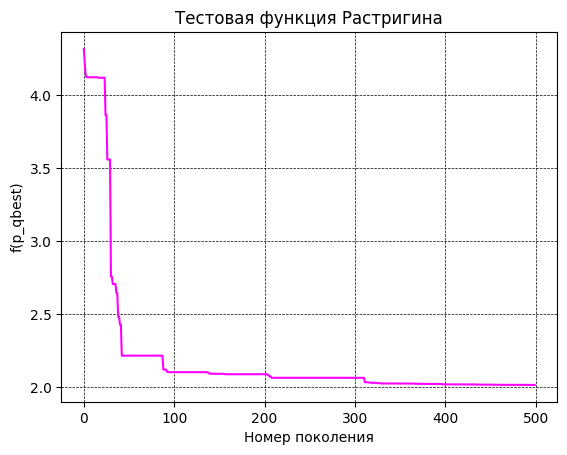

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.03856736  0.97179748]
The function value of pqbest:		1.394644683808366
Algorithm running time:			0.021004438400268555 s


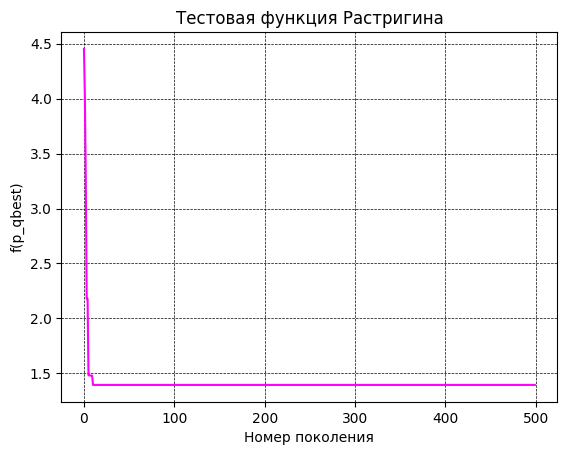

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 0.01238853 -1.02269198]
The function value of pqbest:		1.1778022088854136
Algorithm running time:			0.022022247314453125 s


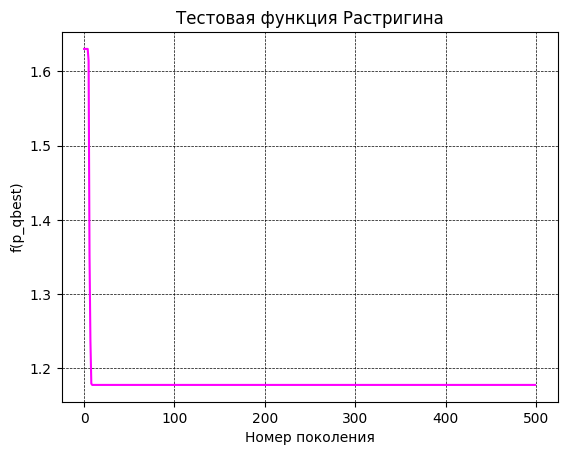

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.02856353  0.0255512 ]
The function value of pqbest:		0.29067776148266944
Algorithm running time:			0.021004438400268555 s


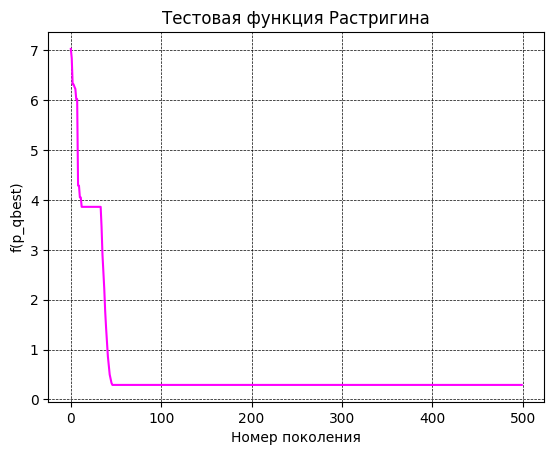

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 7.51703339e-04 -1.99106529e+00]
The function value of pqbest:		3.9802065749930406
Algorithm running time:			0.020003318786621094 s


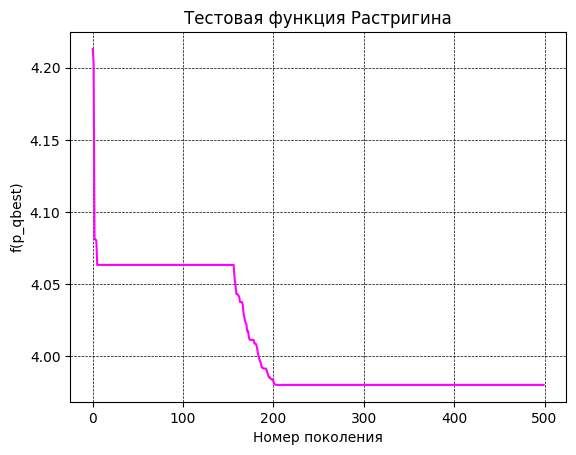

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[0.95510409 0.06527657]
The function value of pqbest:		2.1410943817924775
Algorithm running time:			0.020999670028686523 s


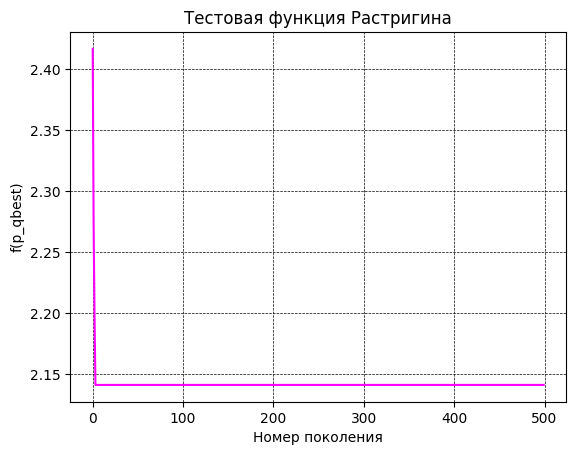

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[ 0.03896916 -1.03729786]
The function value of pqbest:		1.6491132312734536
Algorithm running time:			0.021015405654907227 s


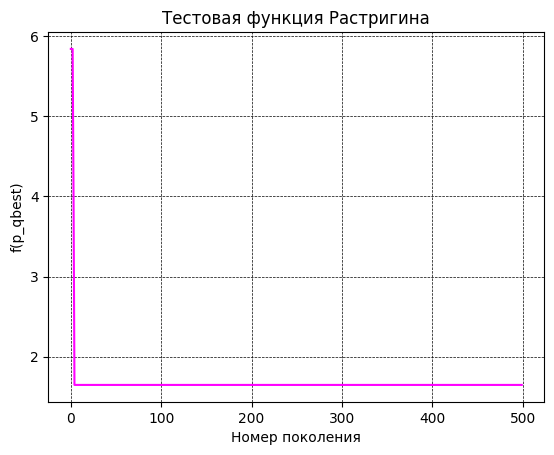

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[-1.13391371  0.0490436 ]
The function value of pqbest:		5.095040806990514
Algorithm running time:			0.021378040313720703 s


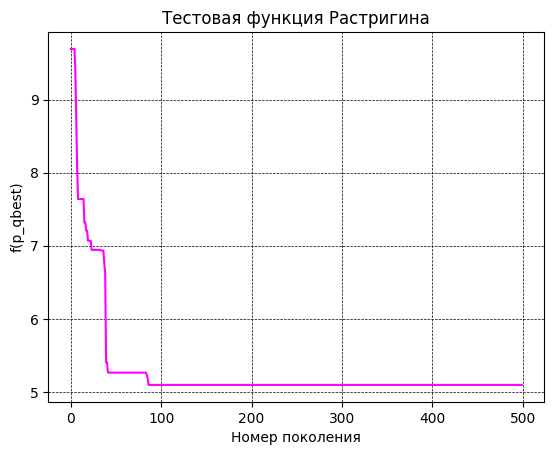

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 1.02589783 -0.04620272]
The function value of pqbest:		1.6051198680587717
Algorithm running time:			0.021004438400268555 s


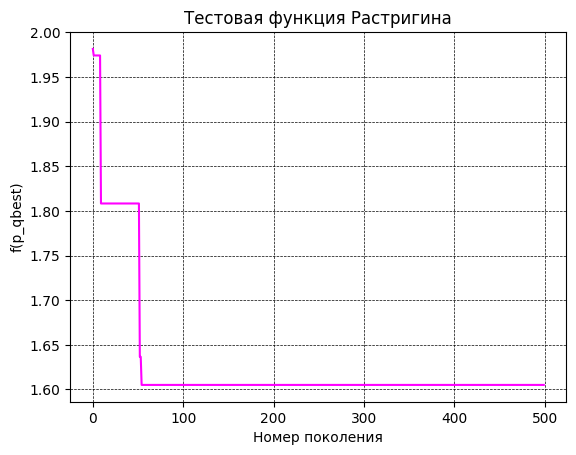

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-1.02857335 -0.93692196]
The function value of pqbest:		2.871675928064718
Algorithm running time:			0.02099132537841797 s


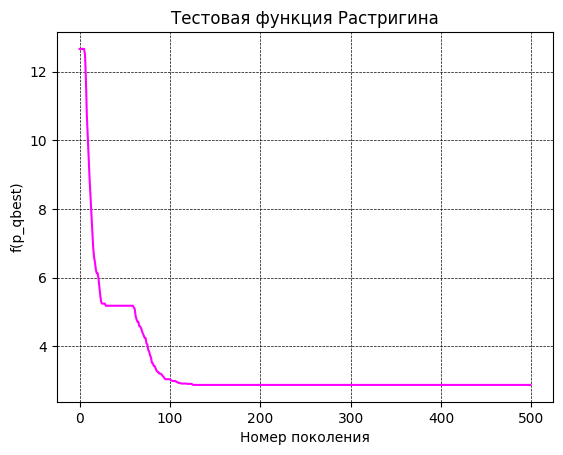

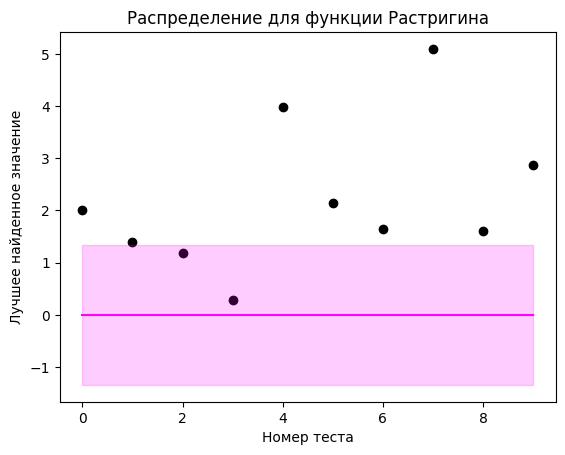

In [578]:
start_test("Растригина")

##Тестовая функция Экли
![picture_of_Ekli](src/Экли.png)


In [579]:
@njit()
def f(x):  # Тестовая функция Экли
    result = -20 * exp(-0.2 * (0.5 * (x[0] ** 2 + x[1] ** 2)) ** 0.5) \
             - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + e + 20
    return result

##Генерация начальных агентов

In [580]:
@njit()
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-5, 5, n_args_count)
    return result

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[0.99269091 0.00140224]
The function value of pqbest:		2.6210626785143276
Algorithm running time:			0.02000880241394043 s


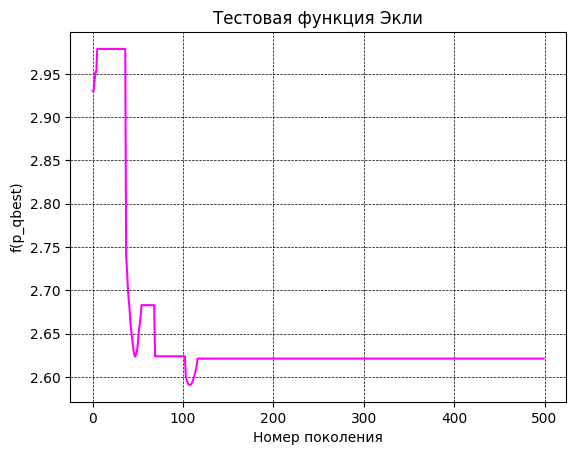

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[ 0.0029283  -0.97773893]
The function value of pqbest:		2.5962652388749206
Algorithm running time:			0.020017385482788086 s


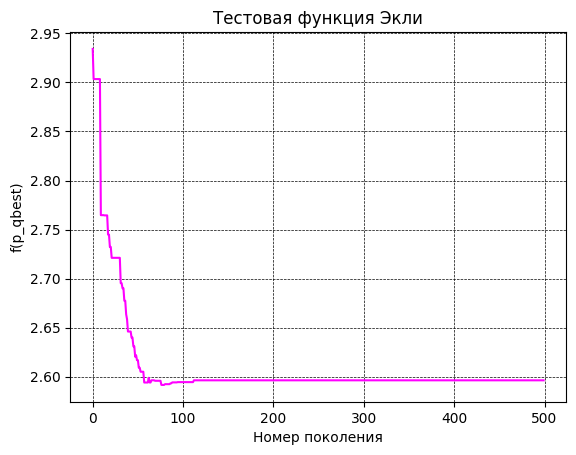

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[0.92211699 0.12306352]
The function value of pqbest:		2.9601611237002317
Algorithm running time:			0.022013187408447266 s


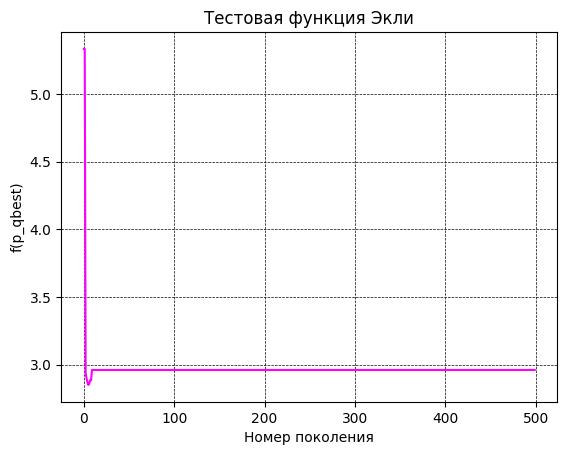

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.00546339  0.9849903 ]
The function value of pqbest:		2.6075058831819717
Algorithm running time:			0.02300548553466797 s


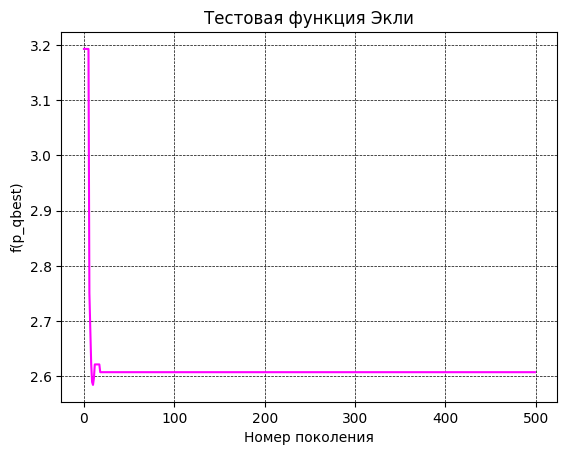

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[-2.00227957  0.03838733]
The function value of pqbest:		4.972072788486592
Algorithm running time:			0.02202296257019043 s


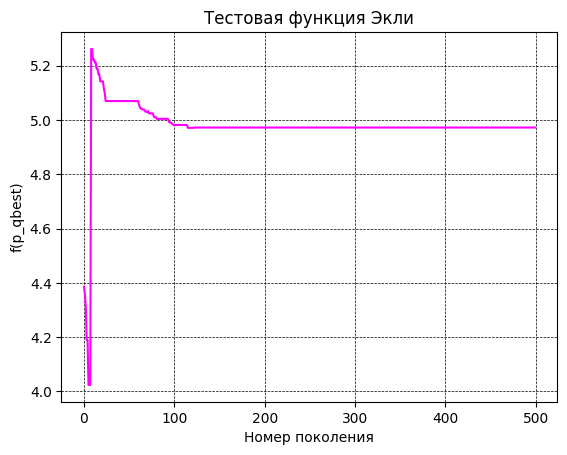

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.0514789 -1.0474438]
The function value of pqbest:		2.8840617133624953
Algorithm running time:			0.022005081176757812 s


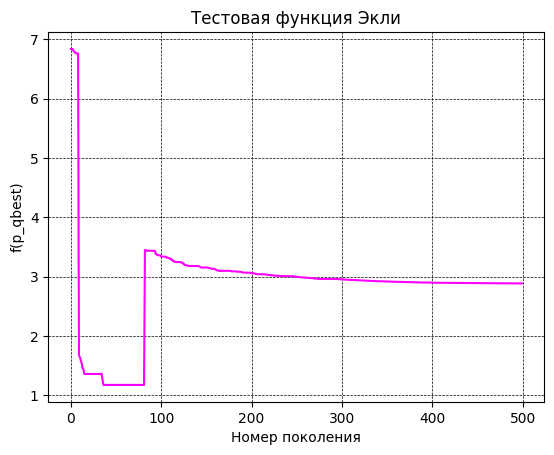

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[ 1.05303442 -2.11554447]
The function value of pqbest:		6.0687572232448055
Algorithm running time:			0.023602962493896484 s


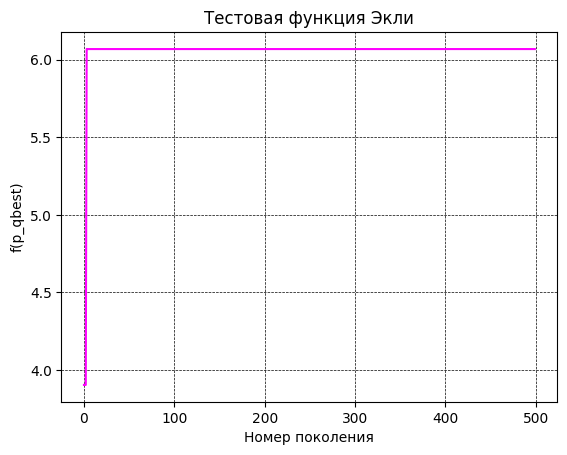

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[0.05161925 1.06341921]
The function value of pqbest:		2.9672856044941476
Algorithm running time:			0.020991086959838867 s


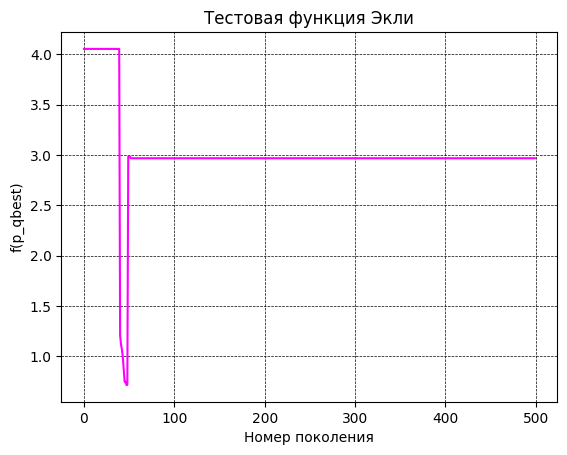

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-0.03322054 -1.96515096]
The function value of pqbest:		4.9146189716422874
Algorithm running time:			0.025022029876708984 s


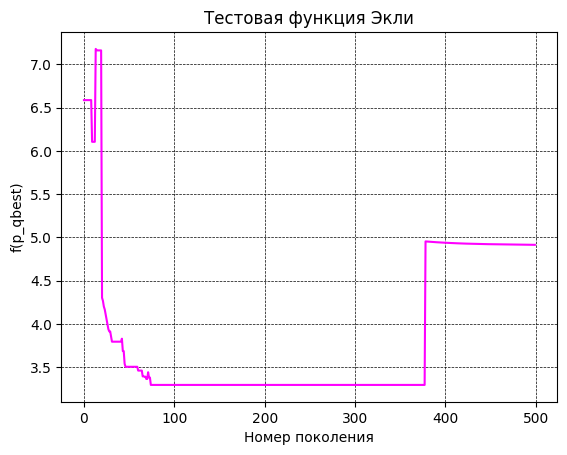

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-1.00786724  2.00188152]
The function value of pqbest:		5.434622936894716
Algorithm running time:			0.021988630294799805 s


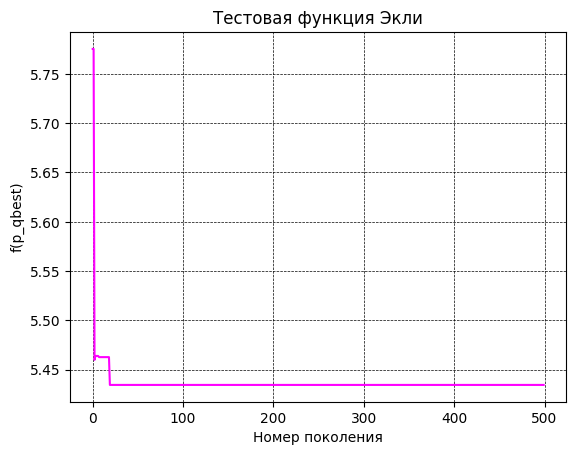

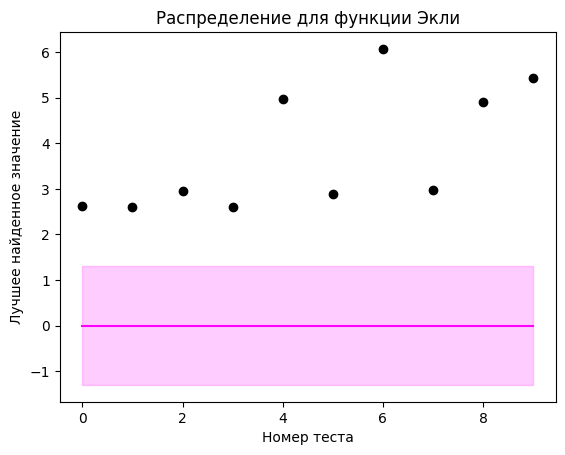

In [581]:
start_test("Экли")


##Тестовая функция Сферы
![picture_of_Sphere](src/сфера.png)

In [582]:
@njit()
def f(x):  # Тестовая функция Сферы
    result = 0
    for i in x:
        result += i ** 2
    return result

##Генерация начальных агентов

In [583]:
@njit()
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-32767, 32767, n_args_count)
    return result

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-1.00767847  0.01836003]
The function value of pqbest:		1.0157529910684613
Algorithm running time:			0.020993471145629883 s


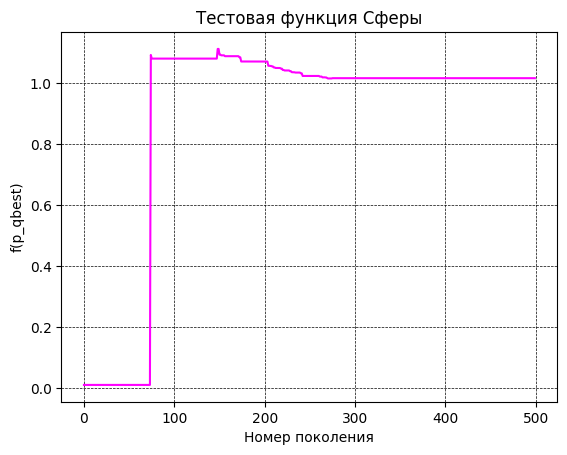

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.0511871  -0.92188726]
The function value of pqbest:		0.8524962431664522
Algorithm running time:			0.02200460433959961 s


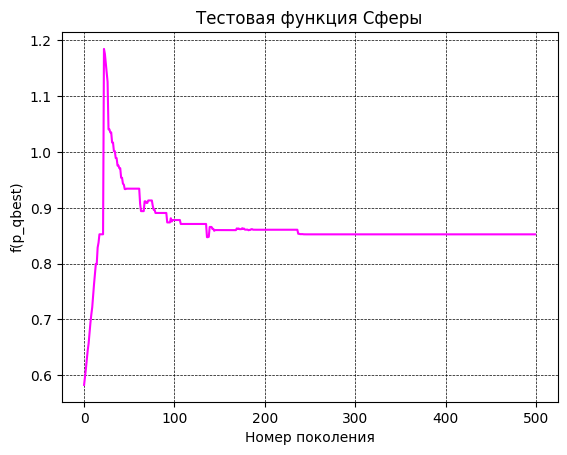

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 1.00125551 -1.98333241]
The function value of pqbest:		4.936120034620596
Algorithm running time:			0.02101731300354004 s


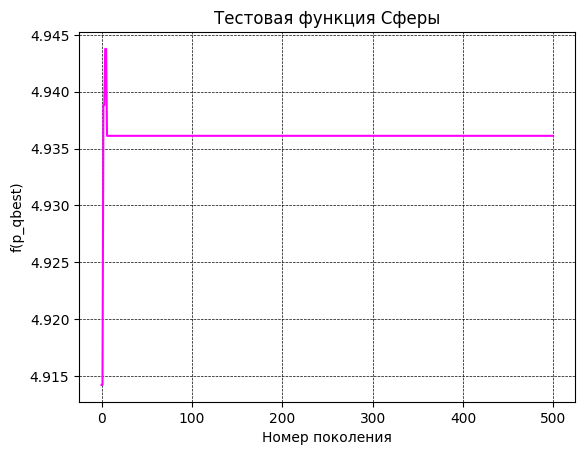

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[1.03506587 0.95096682]
The function value of pqbest:		1.9756992494758912
Algorithm running time:			0.02100348472595215 s


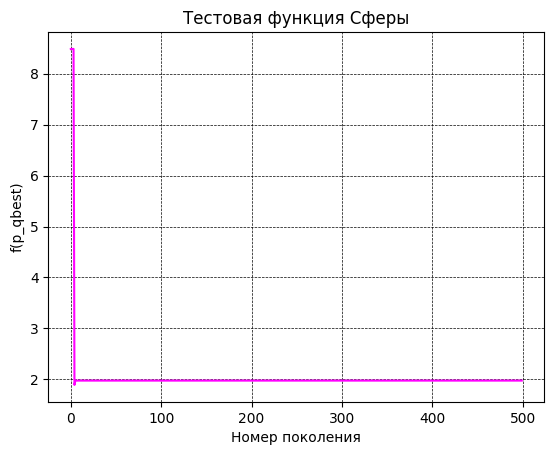

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[-0.04616702 -0.92687892]
The function value of pqbest:		0.8612359331072824
Algorithm running time:			0.023015737533569336 s


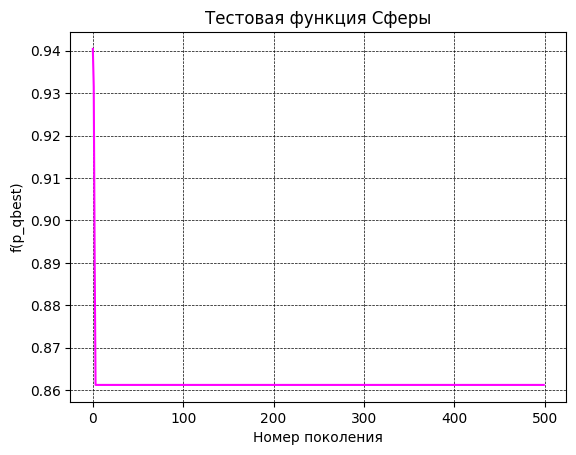

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.06478748 -0.91523275]
The function value of pqbest:		0.8418483962180713
Algorithm running time:			0.02201557159423828 s


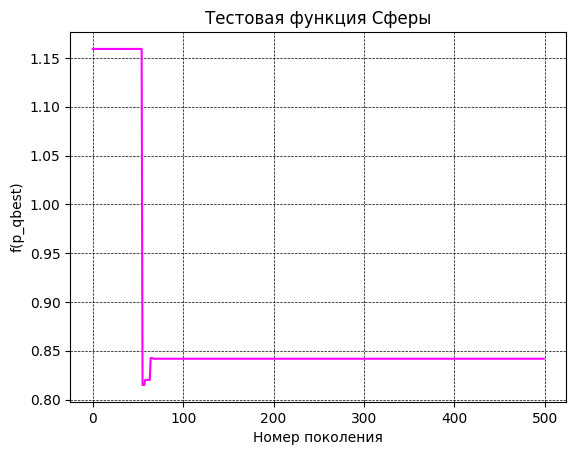

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[ 0.02933919 -0.08025766]
The function value of pqbest:		0.0073020795468394005
Algorithm running time:			0.021999120712280273 s


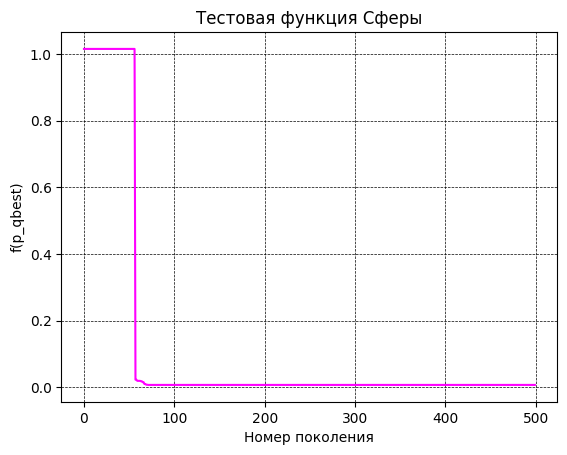

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[1.00450063 1.99023662]
The function value of pqbest:		4.970063332814181
Algorithm running time:			0.02101588249206543 s


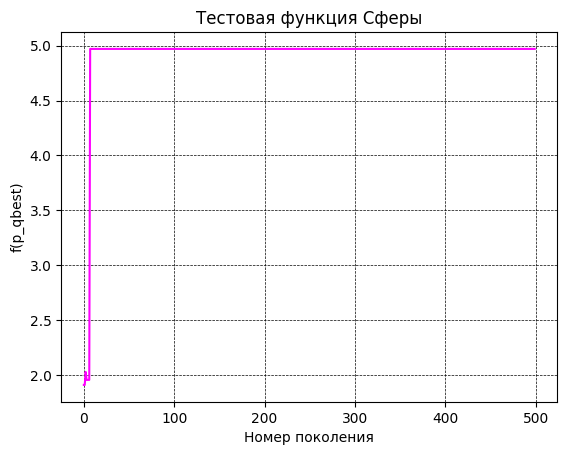

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[0.91143401 0.07142065]
The function value of pqbest:		0.8358128674339834
Algorithm running time:			0.02200007438659668 s


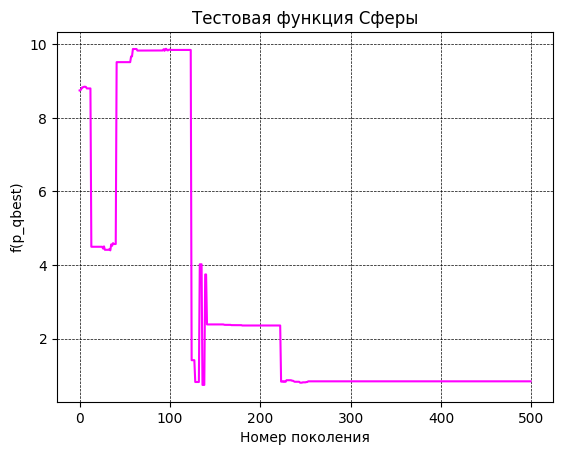

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.02565675  1.02151882]
The function value of pqbest:		1.0441589597774144
Algorithm running time:			0.02399921417236328 s


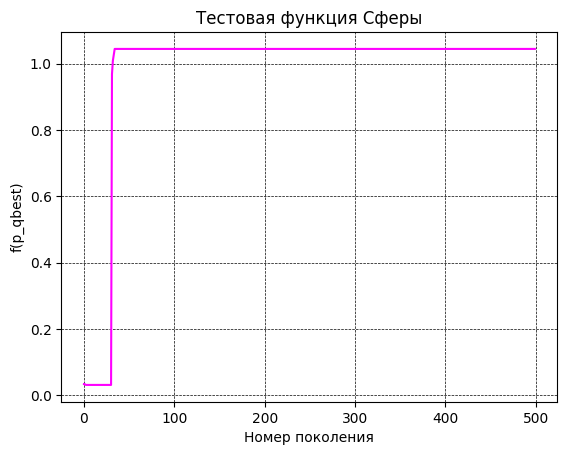

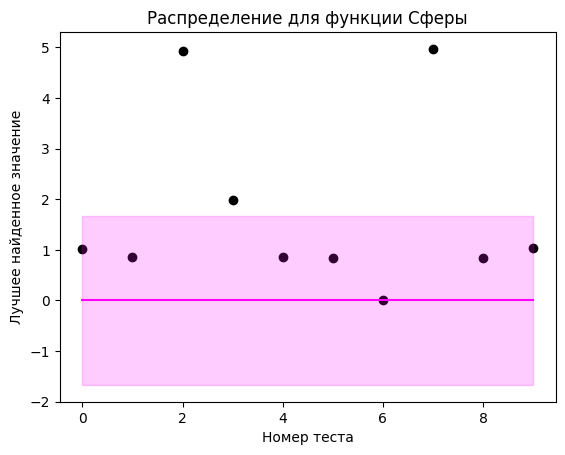

In [584]:
start_test("Сферы")